<a href="https://colab.research.google.com/github/ageryw/Binary-Classification-using-keras-and-Deep-Learning-/blob/master/Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Some practice Codes**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
import os
import copy
import datetime
import argparse
from operator import eq
from torch.utils.data import SubsetRandomSampler

In [ ]:
pretrained = 1
augmentation=1
learningrate = 0.00001
numworkers = 2
batchsize = 16
model = 'vgg16'
epochs =  30
datafolder = 'Datasets/TrainVal'
rootdir = 'default/'


print(rootdir)
if(not os.path.isdir(rootdir)):
    os.mkdir(rootdir)
else:
    pass

log_dir = os.path.join(rootdir,"log")
pth_dir = os.path.join(rootdir,"pth")

if(not os.path.isdir(log_dir)):
    os.mkdir(log_dir)

if(not os.path.isdir(pth_dir)):
    os.mkdir(pth_dir)

if pretrained==1:
    pt_str = "pt" 
    pt = True
else:
    pt_str = "npt"
    pt = False

if augmentation==1:
    aug_str = "aug"
else:
    aug_str = "org"


log_file = log_dir + "/" + model + "_" + aug_str + "_" + pt_str +  ".txt"
pth_file = pth_dir + "/" + model + "_" + aug_str + "_" + pt_str +  ".pth"

log = open(log_file, "a+")

init_scale = 1.15


default/


In [ ]:
data_transforms = transforms.Compose([
        transforms.ColorJitter(brightness=0.1,contrast=0.2,saturation=0.2,hue=0.1),
        transforms.RandomAffine(360,scale=[init_scale-0.15,init_scale+0.15]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
])

In [ ]:
data_dir = datafolder
image_datasets = datasets.ImageFolder(os.path.join(data_dir),transform=data_transforms)

class_names = image_datasets.classes
dataset_sizes = [500,501]
training_set = torch.utils.data.random_split(image_datasets,[500,501])

dataloaders = {x: torch.utils.data.DataLoader(training_set[x], batch_size=batchsize,
                                             shuffle=True, num_workers=numworkers)
                for x in range(2)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_, classes = next(iter(dataloaders[0]))

In [ ]:
# We use 100 of 500 images in each folds for validation set. Rest 400 images are training set
tr_sequence = [[1,0],[0,1]]
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    # 1. Average validation accuracy for each epochs.
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_since = time.time()
        if(epoch%10 == 0):
            print("Checkpoint saved ... Epoch : ", epoch)
            torch.save(model_ft.state_dict(), pth_file.replace(".pth","_"+str(epoch)+".pth"))
        scheduler.step() # A step : An epoch
        print("----- Epoch : {} -----".format(epoch))
        for param_group in optimizer.param_groups:
            # Current learning rate ...
            print("Learning rate : ",param_group['lr'])

        epoch_val_sum = 0

        for i in range(2): # 2 folds...
            print("---> Fold : {}".format(i))
            for f in tr_sequence[i]:# Iterate for folds...
                if f == 'train': # Training Set
                    model.train()  # Set model to training mode
                else: # Validation Set
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data for current set of the fold.
                for inputs, labels in dataloaders[f]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(f is not i):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if f is not i:
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[f]
                epoch_acc = running_corrects.double() / dataset_sizes[f]
                
                if(f == i):
                    print('Validation({}) - Loss: {:.4f}, Acc: {:.4f}'.format(
                        f, epoch_loss, epoch_acc))
                    epoch_val_sum = epoch_val_sum + epoch_acc
                else:
                    print('Training({}) - Loss: {:.4f}, Acc: {:.4f}'.format(
                        f, epoch_loss, epoch_acc))
                # deep copy the model

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_since
        print("-"*20)
        print('Epoch time : {:.0f}m {:.0f}s'.format(
            epoch_time // 60, epoch_time % 60))

        estimated_time = (num_epochs-epoch)*epoch_time
        print('Estimated time ({:.0f}/{:.0f}) : {:.0f}m {:.0f}s'.format(
            epoch, num_epochs, estimated_time // 60, estimated_time % 60))
        
        epoch_val = epoch_val_sum/5
        if epoch_val > best_acc:
            best_acc = epoch_val
            best_model_wts = copy.deepcopy(model.state_dict())
        print("Epoch {} accuracy : {}".format(epoch,epoch_val))
        log.write("{}\n".format(epoch_val))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
if pretrained==1:
    pt = True
else:
    pt = False

print("Using ",torch.cuda.device_count(),"GPU.")
if model == "vgg16":
    model_ft = models.vgg16(pretrained=pt)

    model_ft = torch.nn.DataParallel(model_ft)
    model_ft.to(device)

    num_ftrs = model_ft.module.classifier[6].in_features
    model_ft.module.classifier[6] = torch.nn.Linear(num_ftrs, 2)
elif model == "resnet50":
    model_ft = models.resnet50(pretrained=pt)

    model_ft = torch.nn.DataParallel(model_ft)
    model_ft.to(device)
    
    num_ftrs = model_ft.module.fc.in_features
    model_ft.module.fc = nn.Linear(num_ftrs, 2)
else:
    print("Model ", model, " Build your own model.")
    exit()


Using  1 GPU.


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=learningrate)
# Decay LR by a factor of 0.75 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.75)

print("-"*20)

if pt == True:
    print("Finetuning all layers")
else:
    print("Training from scratch") 

print("Filename : {}".format(pth_file))
print("Model : ", model)
print("-"*20)

log.write("*"*20+"\n")

model_ft = model_ft.cuda()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)

torch.save(model_ft.state_dict(), pth_file)
print("Model state saved to : " + pth_file)
print("-"*20)

In [ ]:
import os
import os.path
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import time
import argparse
from PIL import Image
from torch import nn
from torchvision import models, transforms, utils

In [ ]:
quiet = 0
model = 'vgg16'
weight = 'default/pth/vgg16_aug_pt.pth'
testset = 'Datasets/Test/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
if model == "vgg16":
    model = models.vgg16(pretrained=False)
    model.eval()
    model = torch.nn.DataParallel(model)

    num_ftrs = model.module.classifier[6].in_features
    model.module.classifier[6] = torch.nn.Linear(num_ftrs, 2)
elif model == "resnet50":
    model = models.resnet50(pretrained=False)
    model.eval()
    model = torch.nn.DataParallel(model)
    model.to(device)
    
    num_ftrs = model.module.fc.in_features
    model.module.fc = nn.Linear(num_ftrs, 2)

else:
    print("Model ", model, " not supported.")
    exit()

In [ ]:
target_model = weight

model.load_state_dict(torch.load(target_model))
model.eval()
model.to(device)
print("="*50)
print("Testing the model : {}".format(target_model))
data_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

Testing the model : default/pth/vgg16_aug_pt.pth


In [ ]:
classes = {}

with open('./mosquitos_words.txt') as lines:
    for idx, line in enumerate(lines):
        line = line.strip().split(' ', 1)[1]
        line = line.split(', ', 1)[0]
        classes[idx] = line

In [ ]:
im_dir = testset
scores = np.zeros((2,2))
partial_img_cnt = 0
total_img_cnt = 0

start = time.time()
correct_count = 0
input_name = weight.split(sep='/')[-1].split(sep='.')[-2]
mis_dir = os.path.join("./",input_name+"_mis")
if(os.path.isdir(mis_dir) == False):
    os.mkdir(mis_dir)

In [ ]:
for key, value in classes.items():
    class_dir = im_dir + value
    im_list = os.listdir(class_dir)
    if(quiet == 0):
        print("Processing ... ", value)
    class_count = np.zeros(2)
    for idx, img in enumerate(im_list):
        if img.split('.')[1] == 'txt':
            continue
        image_name = class_dir+"/"+img
        raw_image = cv2.imread(image_name)[..., ::-1]
        im_pil = Image.fromarray(raw_image)
        image = data_transforms(im_pil).unsqueeze(0)

        pred_list = model(image)
        pred_list = pred_list.cpu().detach().numpy()[0]
        pred = np.argmax(pred_list)
        total_img_cnt = total_img_cnt + 1
        if(pred != key): # Misclassfication cases
            pilImage = transforms.ToPILImage()(image.squeeze(0))
            mis_img_dir = os.path.join(mis_dir, classes[key])
            if(os.path.isdir(mis_img_dir) == False):
                os.mkdir(mis_img_dir)
            pilImage.save(os.path.join(mis_img_dir,
                          str(partial_img_cnt) + "_" + value + "_to_" + classes[pred] +'.png'))
        else:
            correct_count = correct_count+1
        class_count[pred] = class_count[pred]+1
        partial_img_cnt = partial_img_cnt + 1
    class_scores = (class_count/partial_img_cnt)*100
    scores[key] = class_scores
    partial_img_cnt=0

Processing ...  AeAl
Processing ...  NotAeAl


In [ ]:
test_accuracy = correct_count/total_img_cnt
scores = np.around(scores,decimals=2)
print("----- Confusion Matrx (%) -----")
print(scores)
print("-------------------------------")
print("Correct {} of {}.".format(correct_count,total_img_cnt))
print("Test Accuracy : {:.2f}%".format(test_accuracy*100))
end = time.time()
    
print("Elapsed time : {:.2f} [sec]".format(end-start))

print("="*50)

----- Confusion Matrx (%) -----
[[ 94.   6.]
 [  0. 100.]]
-------------------------------
Correct 965 of 995.
Test Accuracy : 96.98%
Elapsed time : 18.78 [sec]


In [ ]:
from collections import OrderedDict

import numpy as np
import torch
import cv2
from torch.nn import functional as F

# -- GradCAM --
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

def normalize(input):
    output = (input - np.min(input)) / (np.max(input) - np.min(input))
    return output

def save_gradient(filename, data):
    data -= data.min()
    data /= data.max()
    data *= 255.0
    cv2.imwrite(filename, np.uint8(data))

def save_gradcam(filename, gcam, raw_image):
    h, w, _ = raw_image.shape
    gcam = cv2.resize(gcam, (w, h))
    gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
    gcam = gcam.astype(np.float) + raw_image.astype(np.float)
    gcam = gcam / gcam.max() * 255.0
    cv2.imwrite(filename, np.uint8(gcam))

def save_raw_image(filename, raw_image):
    cv2.imwrite(filename, np.uint8(raw_image))

class _PropagationBase(object):
    def __init__(self, model):
        super(_PropagationBase, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.image = None

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.to(self.device)

    def forward(self, image):
        self.image = image.requires_grad_()
        self.model.zero_grad()
        self.preds = self.model(self.image)
        self.probs = F.softmax(self.preds, dim=1)[0]
        self.prob, self.idx = self.probs.sort(0, True)
        return self.prob, self.idx

    def backward(self, idx):
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)

class GradCAM(_PropagationBase):
    def __init__(self, model):
        super(GradCAM, self).__init__(model)
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()

        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.detach()

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].detach()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm

    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        return F.adaptive_avg_pool2d(grads, 1)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = (fmaps[0] * weights[0]).sum(dim=0)
        gcam = torch.clamp(gcam, min=0.)

        gcam -= gcam.min()
        gcam /= gcam.max()

        return gcam.detach().cpu().numpy()

In [ ]:
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import argparse
import os

In [ ]:
weights = 'default/pth/vgg16_aug_pt.pth'
input = 'Datasets/Test/AeAl/0_0_Aa_2.JPG'
output = 'results/'

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096,2)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(weights))
model = model.module
model.eval()
model.to(device)

data_transforms = transforms.Compose([
    transforms.ToTensor()
])


In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
### Target layers (VGG16)
targets = [
    "features.0",
    "features.2",
    "features.5",
    "features.7",
    "features.10",
    "features.12",
    "features.14",
    "features.17",
    "features.19",
    "features.21",
    "features.24",
    "features.26",
    "features.28",
]

In [ ]:
image_num = 0
input_image = input

# =========================================================================
print('='*20)
# =========================================================================

print(f"Processing image \'{input_image}\'")

raw_image = cv2.imread(input_image)[..., ::-1]
im_pil = Image.fromarray(raw_image)

image = data_transforms(im_pil).unsqueeze(0)
image_var = Variable(image)

a = transforms.ToPILImage()(image.squeeze())


Processing image 'Datasets/Test/AeAl/0_0_Aa_2.JPG'


In [ ]:
tr_image = np.asarray(np.transpose(image.squeeze(0),(1,2,0)))
tr_image = cv2.cvtColor(tr_image,cv2.COLOR_BGR2RGB)
tr_image = np.uint8(normalize(tr_image)*255)
image_name = input_image.split(sep="/")[-1].split(sep=".")[-2]
save_dir = os.path.join(output,image_name)
if(os.path.isdir(save_dir)):
    print('Save directory exists')
else:
    os.mkdir(save_dir)
print('Visualization saved to : ',save_dir)

a.save(os.path.join(save_dir,'_input_image'+'.jpg'))
gcam = GradCAM(model=model)
probs, idx = gcam.forward(image_var.to(device))

Visualization saved to :  results/0_0_Aa_2


In [ ]:
print("-"*30)
print("|  Probability  |    Class   |")
print("-"*30)
for i in range(0, 2):
    for j in range(0,len(targets)):
        gcam.backward(idx=idx[i])
        output = gcam.generate(target_layer=targets[j])
        # Filename : {ClassName}_gcam_{NumLayer}
        #save_gradcam(save_dir+'/{}_gcam_{}.png'.format(classes[idx[i]], targets[j]), output, tr_image)
    #print('[{:.5f}] {}'.format(probs[i], classes[idx[i]]))

------------------------------
|  Probability  |    Class   |
------------------------------


In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar

--2020-07-09 13:07:02--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... ^C
--2020-07-09 13:08:21--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... ^C
--2020-07-09 13:08:31--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... ^C


## Train Minist

In [ ]:
import os
import random
import argparse
import numpy as np
from tensorboardX import SummaryWriter
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size = 64
epochs = 2
lr = 0.001 # initial learning rate
outf ='logs/' #path of log files
attn_mode = 'before' # insert attention modules before OR after maxpooling layers
normalize_attn = True #if True, attention map is normalized by softmax; otherwise use sigmoid
no_attention = False # turn down attention
log_images = True # log images and (is available) attention maps
im_size = 32
num_aug = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## load data
# CIFAR-100: 500 training images and 100 testing images per class
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

## load network
print('\nloading the network ...\n')
# use attention module?
if not no_attention:
    print('\nturn on attention ...\n')
else:
    print('\nturn off attention ...\n')
# (linear attn) insert attention befroe or after maxpooling?
# (grid attn only supports "before" mode)
if attn_mode == 'before':
    print('\npay attention before maxpooling layers...\n')
    net = AttnVGG_before(im_size=im_size, num_classes=10,
        attention=not no_attention, normalize_attn=normalize_attn, init='xavierUniform')
elif attn_mode == 'after':
    print('\npay attention after maxpooling layers...\n')
    net = AttnVGG_after(im_size=im_size, num_classes=10,
        attention=not no_attention, normalize_attn=normalize_attn, init='xavierUniform')
else:
    raise NotImplementedError("Invalid attention mode!")
criterion = nn.CrossEntropyLoss()
print('done')

## move to GPU
print('\nmoving to GPU ...\n')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0]
model = nn.DataParallel(net, device_ids=device_ids).to(device)
criterion.to(device)
print('done')

### optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
lr_lambda = lambda epoch : np.power(0.5, int(epoch/25))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# training
print('\nstart training ...\n')
step = 0
running_avg_accuracy = 0
writer = SummaryWriter(outf)
for epoch in range(epochs):
    images_disp = []
    # adjust learning rate
    scheduler.step()
    writer.add_scalar('train/learning_rate', optimizer.param_groups[0]['lr'], epoch)
    print("\nepoch %d learning rate %f\n" % (epoch, optimizer.param_groups[0]['lr']))
    # run for one epoch
    for aug in range(num_aug):
        for i, data in enumerate(trainloader, 0):
            # warm up
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            if (aug == 0) and (i == 0): # archive images in order to save to logs
                images_disp.append(inputs[0:36,:,:,:])
            # forward
            pred, __, __, __ = model(inputs)
            # backward
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            # display results
            if i % 10 == 0:
                model.eval()
                pred, __, __, __ = model(inputs)
                predict = torch.argmax(pred, 1)
                total = labels.size(0)
                correct = torch.eq(predict, labels).sum().double().item()
                accuracy = correct / total
                running_avg_accuracy = 0.9*running_avg_accuracy + 0.1*accuracy
                writer.add_scalar('train/loss', loss.item(), step)
                writer.add_scalar('train/accuracy', accuracy, step)
                writer.add_scalar('train/running_avg_accuracy', running_avg_accuracy, step)
                print("[epoch %d][aug %d/%d][%d/%d] loss %.4f accuracy %.2f%% running avg accuracy %.2f%%"
                    % (epoch, aug, num_aug-1, i, len(trainloader)-1, loss.item(), (100*accuracy), (100*running_avg_accuracy)))
            step += 1
    # the end of each epoch: test & log
    print('\none epoch done, saving records ...\n')
    torch.save(model.state_dict(), os.path.join(outf, 'net.pth'))
    if epoch == epochs / 2:
        torch.save(model.state_dict(), os.path.join(outf, 'net%d.pth' % epoch))
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # log scalars
        for i, data in enumerate(testloader, 0):
            images_test, labels_test = data
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            if i == 0: # archive images in order to save to logs
                images_disp.append(inputs[0:36,:,:,:])
            pred_test, __, __, __ = model(images_test)
            predict = torch.argmax(pred_test, 1)
            total += labels_test.size(0)
            correct += torch.eq(predict, labels_test).sum().double().item()
        writer.add_scalar('test/accuracy', correct/total, epoch)
        print("\n[epoch %d] accuracy on test data: %.2f%%\n" % (epoch, 100*correct/total))
        # log images
        if log_images:
            print('\nlog images ...\n')
            I_train = utils.make_grid(images_disp[0], nrow=6, normalize=True, scale_each=True)
            writer.add_image('train/image', I_train, epoch)
            if epoch == 0:
                I_test = utils.make_grid(images_disp[1], nrow=6, normalize=True, scale_each=True)
                writer.add_image('test/image', I_test, epoch)
        if log_images and (not no_attention):
            print('\nlog attention maps ...\n')
            # base factor
            if attn_mode == 'before':
                min_up_factor = 1
            else:
                min_up_factor = 2
            # sigmoid or softmax
            if normalize_attn:
                vis_fun = visualize_attn_softmax
            else:
                vis_fun = visualize_attn_sigmoid
            # training data
            __, c1, c2, c3 = model(images_disp[0])
            if c1 is not None:
                attn1 = vis_fun(I_train, c1, up_factor=min_up_factor, nrow=6)
                writer.add_image('train/attention_map_1', attn1, epoch)
            if c2 is not None:
                attn2 = vis_fun(I_train, c2, up_factor=min_up_factor*2, nrow=6)
                writer.add_image('train/attention_map_2', attn2, epoch)
            if c3 is not None:
                attn3 = vis_fun(I_train, c3, up_factor=min_up_factor*4, nrow=6)
                writer.add_image('train/attention_map_3', attn3, epoch)
            # test data
            __, c1, c2, c3 = model(images_disp[1])
            if c1 is not None:
                attn1 = vis_fun(I_test, c1, up_factor=min_up_factor, nrow=6)
                writer.add_image('test/attention_map_1', attn1, epoch)
            if c2 is not None:
                attn2 = vis_fun(I_test, c2, up_factor=min_up_factor*2, nrow=6)
                writer.add_image('test/attention_map_2', attn2, epoch)
            if c3 is not None:
                attn3 = vis_fun(I_test, c3, up_factor=min_up_factor*4, nrow=6)
                writer.add_image('test/attention_map_3', attn3, epoch)

## Torch practive

In [ ]:
import torch
import torch.nn as nn
import numpy as np 
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0) prepare the datasets
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target
n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =1234)
#scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

#reshape
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# 1) Build the Model 
class LogReg(nn.Module):
  def __init__(self, n_input_features):
    super(LogReg, self).__init__()
    self.linear = nn.Linear(n_input_features,1)
  
  def forward(self, x):
    self.x = self.linear(x)
    predicted = torch.sigmoid(self.x)
    return predicted

model = LogReg(n_features)

# 2) Loss and Optimizer
learning_rate = 0.01
criterion = nn.BCELoss()
Optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# 3) Train loop
num_epoch = 100
for epoch in range(num_epoch):
  #forward pass
  y_predicted = model(X_train)
  loss = criterion(y_predicted, y_train)
  y_predicted_cls = y_predicted.round()
  acc = y_predicted_cls.eq(y_train).sum() / float(y_train.shape[0])
  #backward pass
  loss.backward()

  #update weights
  Optimizer.step()
  Optimizer.zero_grad()

  if (epoch+1)%10 == 0:
    print(f'epoch: {epoch+1}, Loss = {loss.item():.4f}, Accuracy = {acc:.4f}')

with torch.no_grad():
  y_predicted = model(X_test)
  y_predicted_cls = y_predicted.round()
  accuracy = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
  print(f'Test accuracy: {accuracy:4f}')

epoch: 10, Loss = 0.6650, Accuracy = 0.6330
epoch: 20, Loss = 0.5348, Accuracy = 0.8505
epoch: 30, Loss = 0.4551, Accuracy = 0.9099
epoch: 40, Loss = 0.4015, Accuracy = 0.9297
epoch: 50, Loss = 0.3627, Accuracy = 0.9363
epoch: 60, Loss = 0.3331, Accuracy = 0.9363
epoch: 70, Loss = 0.3097, Accuracy = 0.9385
epoch: 80, Loss = 0.2907, Accuracy = 0.9385
epoch: 90, Loss = 0.2747, Accuracy = 0.9407
epoch: 100, Loss = 0.2611, Accuracy = 0.9429
Test accuracy: 0.921053


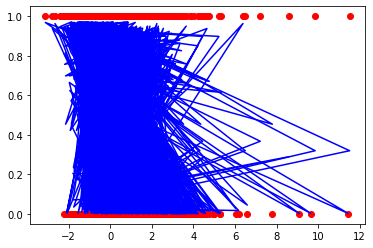

In [ ]:
import matplotlib.pyplot as plt

predicted = model(X_train).detach().numpy()
plt.plot(X_train, y_train, 'ro')
plt.plot(X_train, predicted, 'b')
plt.show()

In [ ]:
y_test.shape

torch.Size([114, 1])

## Practice

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#Configure the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#define hyperparameters
input_size = 784
hidden_size = 100 
num_classes = 10
epochs = 2 
batch_size = 100
learning_rate = 0.001

#Define MNIST dataset
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root = './data',train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

examples = iter(train_loader)
samples, labels = examples.next()
'''
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(samples[i][0], cmap = 'gray')
plt.show()
'''
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [ ]:
print(device)

cuda


In [ ]:
#Train
#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#train loop
n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        #Forward
        output = model(images)
        loss = criterion(output, labels)
       # _, prediction = torch.max(output, 1)
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%100 == 0:
            print(f'epoch: {epoch+1}/{epochs}, step : {i+1}/{n_total_steps}, loss={loss.item():.4f}')


epoch: 1/2, step : 100/600, loss=0.5123
epoch: 1/2, step : 200/600, loss=0.2576
epoch: 1/2, step : 300/600, loss=0.2169
epoch: 1/2, step : 400/600, loss=0.2036
epoch: 1/2, step : 500/600, loss=0.2861
epoch: 1/2, step : 600/600, loss=0.1318
epoch: 2/2, step : 100/600, loss=0.2086
epoch: 2/2, step : 200/600, loss=0.3059
epoch: 2/2, step : 300/600, loss=0.1077
epoch: 2/2, step : 400/600, loss=0.1159
epoch: 2/2, step : 500/600, loss=0.0948
epoch: 2/2, step : 600/600, loss=0.1511


In [ ]:
#Test
#Testings
with torch.no_grad():
    n_correct = 0 
    n_samples = 0

    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        
        _, prediction = torch.max(output, 1)

        n_samples += labels.shape[0]
        n_correct += (prediction == labels).sum().item()

acc = 100 * n_correct / n_samples
print(f'Average test accuracy {acc}')

Average test accuracy 95.71


## **Grad-Cam class and percent**

In [ ]:
from collections import OrderedDict

import numpy as np
import torch
import cv2
from torch.nn import functional as F

        

In [ ]:
# -- GradCAM --
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

def normalize(input):
    output = (input - np.min(input)) / (np.max(input) - np.min(input))
    return output


In [ ]:

def save_gradient(filename, data):
    data -= data.min()
    data /= data.max()
    data *= 255.0
    cv2.imwrite(filename, np.uint8(data))

In [ ]:
def save_gradcam(filename, gcam, raw_image):
    
    h, w, _ = raw_image.shape
    gcam = cv2.resize(gcam, (w, h))
    
    gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
    #cv2.imshow(gcam)
    
    gcam = gcam.astype(np.float) + raw_image.astype(np.float)
    gcam = gcam / gcam.max() * 255.0
    cv2.imwrite(filename, np.uint8(gcam))
    cv2.rectangle(gcam,(384,0),(510,128),(0,255,0),3)
    plt.imshow(np.uint8(gcam))
    plt.show()

In [ ]:
def save_raw_image(filename, raw_image):
    cv2.imwrite(filename, np.uint8(raw_image))

In [ ]:
class _PropagationBase(object):
    def __init__(self, model):
        super(_PropagationBase, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.image = None

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.to(self.device)

    def forward(self, image):
        self.image = image.requires_grad_()
        self.model.zero_grad()
        self.preds = self.model(self.image)
        self.probs = F.softmax(self.preds, dim=1)[0]
        self.prob, self.idx = self.probs.sort(0, True)
        return self.prob, self.idx

    def backward(self, idx):
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)

In [ ]:
class GradCAM(_PropagationBase):
    def __init__(self, model):
        super(GradCAM, self).__init__(model)
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()

        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.detach()

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].detach()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm

    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        return F.adaptive_avg_pool2d(grads, 1)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = (fmaps[0] * weights[0]).sum(dim=0)
        
        gcam = torch.clamp(gcam, min=0.)

        gcam -= gcam.min()
        gcam /= gcam.max()
        return gcam.detach().cpu().numpy()

In [ ]:
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import os


In [ ]:
weights ='model.pth'#Pre-trained weight file (*.pth)
input = 'images/002842.png'#Directory for an input image
output = 'gradcams'#Directory for the visualization result

Output directory exists
Processing image 'images/002842.png'
Save directory exists
Visualization saved to :  gradcams/002842
-------------------
------------------------------
|  Probability  |    Class   |
------------------------------


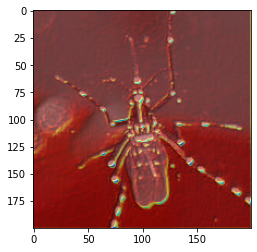

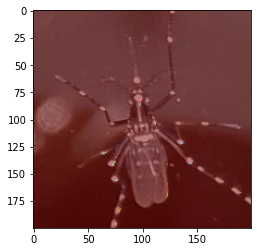

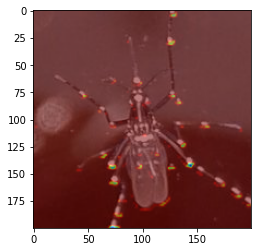

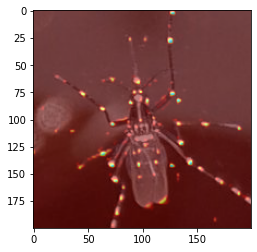

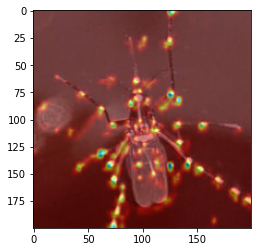

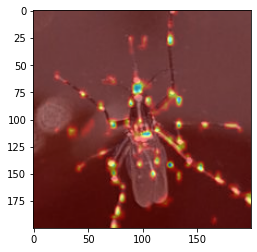

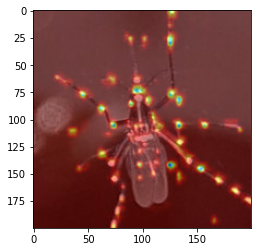

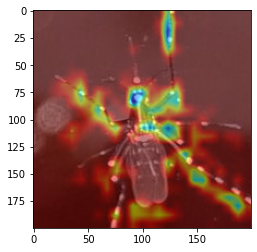

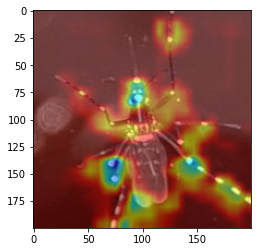

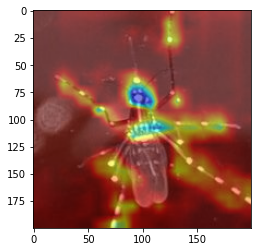

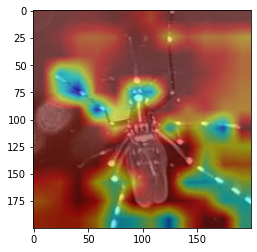

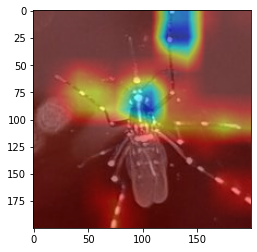

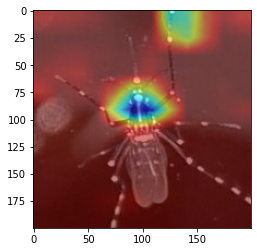

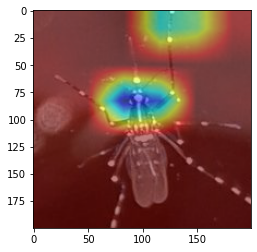

[0.66410] AeAl


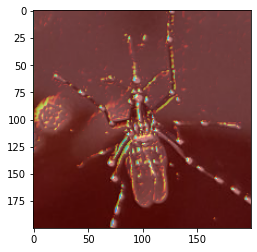

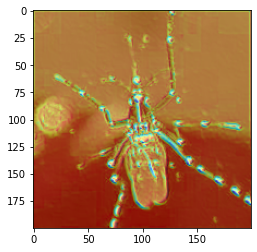

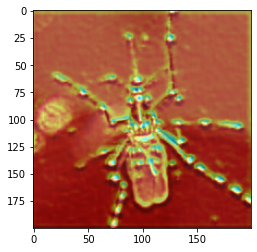

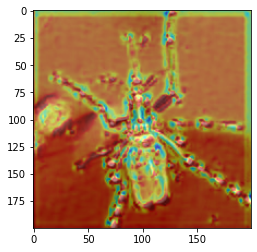

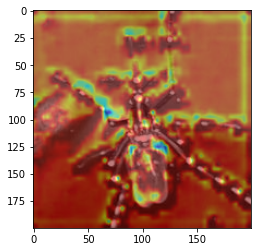

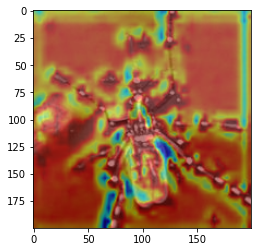

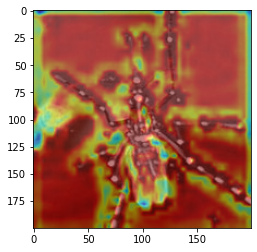

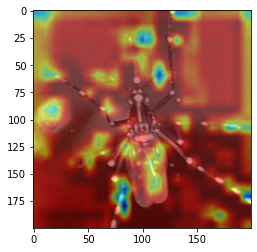

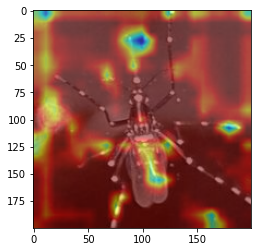

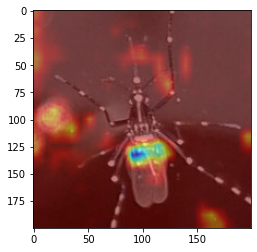

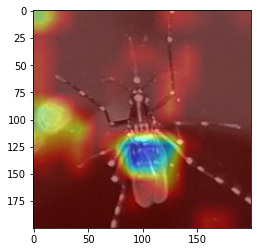

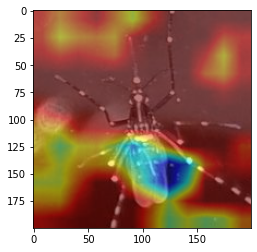

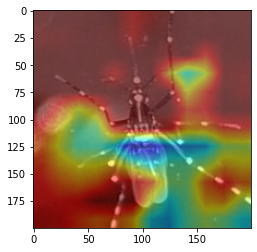

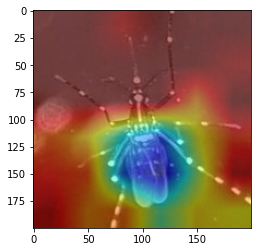

[0.33590] NotAeAl


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ["AeAl", "NotAeAl"]

if (os.path.isdir(output)):
    print('Output directory exists')
else:
    os.mkdir(output)

model = models.vgg16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096,2)
#model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(weights))
#model = model.module
model.eval()
model.to(device)

data_transforms = transforms.Compose([
    transforms.ToTensor()
])
### Target layers (VGG16)

### Target layers (VGG16)
targets = [
    "features.0",
    "features.2",
    "features.5",
    "features.7",
    "features.10",
    "features.12",
    "features.14",
    "features.17",
    "features.19",
    "features.21",
    "features.23",
    "features.26",
    "features.28",
    "features.30",
]
### Target layers (VGG19)
'''
targets = [
    "features.0",
    "features.2",
    "features.5",
    "features.7",
    "features.10",
    "features.12",
    "features.14",
    "features.16",
    "features.19",
    "features.21",
    "features.23",
    "features.25",
    "features.28",
    "features.30",
    "features.32",
    "features.34",
    "features.36",
]
'''
image_num = 0
input_image = input

# =========================================================================
print('='*20)
# =========================================================================

print(f"Processing image \'{input_image}\'")

raw_image = cv2.imread(input_image)[..., ::-1]
im_pil = Image.fromarray(raw_image)

image = data_transforms(im_pil).unsqueeze(0)
image_var = Variable(image)

a = transforms.ToPILImage()(image.squeeze())

tr_image = np.asarray(np.transpose(image.squeeze(0),(1,2,0)))
tr_image = cv2.cvtColor(tr_image,cv2.COLOR_BGR2RGB)
tr_image = np.uint8(normalize(tr_image)*255)
image_name = input_image.split(sep="/")[-1].split(sep=".")[-2]
save_dir = os.path.join(output,image_name)
if(os.path.isdir(save_dir)):
    print('Save directory exists')
else:
    os.mkdir(save_dir)
print('Visualization saved to : ',save_dir)

a.save(os.path.join(save_dir,'_input_image'+'.jpg'))
gcam = GradCAM(model=model)
print('-------------------')
print(gcam)
probs, idx = gcam.forward(image_var.to(device))

print("-"*30)
print("|  Probability  |    Class   |")
print("-"*30)
for i in range(0, 2):
    for j in range(0,len(targets)):
        gcam.backward(idx=idx[i])
        output = gcam.generate(target_layer=targets[j])
        # Filename : {ClassName}_gcam_{NumLayer}
        save_gradcam(save_dir+'/{}_gcam_{}.png'.format(classes[idx[i]], targets[j]), output, tr_image)
    print('[{:.5f}] {}'.format(probs[i], classes[idx[i]]))


In [ ]:
output[:][:]>=0.1

In [ ]:
!zip -r gradcams.zip gradcams/

In [ ]:
model = models.vgg16(pretrained = True)
model

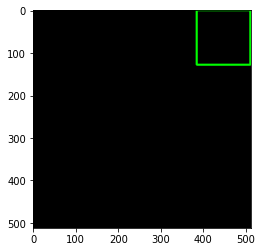

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

img = np.zeros((512,512,3), np.uint8)

img = cv2.rectangle(img,(384,0),(510,128),(0,255,0),3)
plt.imshow(img)
plt.show()